# Fine Tune NER Model

## Importing necessary libraries


In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from datasets import Dataset, Features, Value, ClassLabel, DatasetDict
from datasets import load_metric
import numpy as np
import tempfile
import os

## Preparing dataset


In [ ]:
# Define the features based on the CoNLL format
features = Features({
    "tokens": [Value(dtype='string')],
    "ner_tags": [ClassLabel(names=['O', 'B-Product', 'I-Product', 'B-PRICE', 'I-PRICE', 'B-LOC', 'I-LOC'])]
})

def parse_conll_file(file_path):
    """Parses a CoNLL file into a list of examples."""
    data = []
    tokens = []
    ner_tags = []
    # Get the ClassLabel object from the list
    ner_tag_feature = features["ner_tags"][0]
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                parts = line.split()
                tokens.append(parts[0])

                tag = parts[-1]
                if tag in ner_tag_feature.names:
                    ner_tags.append(tag)
                else:
                     ner_tags.append('O')
            elif tokens:
                if len(tokens) == len(ner_tags):
                    data.append({"tokens": tokens, "ner_tags": ner_tags})
                else:
                    print(f"Skipping malformed example with {len(tokens)} tokens and {len(ner_tags)} tags.")
                tokens = []
                ner_tags = []
        if tokens and len(tokens) == len(ner_tags):
             data.append({"tokens": tokens, "ner_tags": ner_tags})
        elif tokens:
             print(f"Skipping malformed final example with {len(tokens)} tokens and {len(ner_tags)} tags.")
    return data

In [ ]:
# Assuming the dataset file is named 'telegram_data_conll.txt' and is in the /content/ directory
all_data = parse_conll_file("/content/telegram_data_conll.txt")

# Convert the list of examples into a Dataset
full_dataset = Dataset.from_dict({
    "tokens": [example["tokens"] for example in all_data],
    "ner_tags": [example["ner_tags"] for example in all_data]
})


full_dataset = full_dataset.cast(features)

# Split the dataset into training and validation sets
raw_datasets = full_dataset.train_test_split(test_size=0.3, seed=42) # 30% for validation

# Rename the splits for clarity
raw_datasets["train"] = raw_datasets.pop("train")
raw_datasets["validation"] = raw_datasets.pop("test")


# Display the dataset structure to verify
print(raw_datasets)

Casting the dataset:   0%|          | 0/3007 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 2104
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 903
    })
})


In [ ]:
# Load the seqeval metric once
metric = load_metric("seqeval")

def finetune_ner_model(model_name, tokenizer, raw_datasets, label_names):
    """
    Fine-tunes a NER model, evaluates it, and returns the trained model and evaluation results.

    Args:
        model_name (str): The name of the pre-trained model to load from Hugging Face Hub.
        tokenizer: The tokenizer to use.
        raw_datasets (DatasetDict): The raw dataset split into train and validation.
        label_names (list): A list of the NER tag names.

    Returns:
        tuple: A tuple containing the trained model and the evaluation results.
    """

    def tokenize_and_align_labels(examples, tokenizer):
        """Tokenizes the data and aligns labels with tokens."""
        tokenized_inputs = tokenizer(
            examples["tokens"],
            is_split_into_words=True,
            padding="max_length",
            truncation=True
        )

        labels = []
        for i, label in enumerate(examples["ner_tags"]):
            word_ids = tokenized_inputs.word_ids(batch_index=i)
            previous_word_idx = None
            label_ids = []
            for word_idx in word_ids:
                if word_idx is None:
                    label_ids.append(-100)
                elif word_idx != previous_word_idx:
                    label_ids.append(label[word_idx])
                else:
                    label_ids.append(-100)
                previous_word_idx = word_idx
            labels.append(label_ids)

        tokenized_inputs["labels"] = labels
        return tokenized_inputs

    # Apply the function to the raw_datasets
    tokenized_datasets = raw_datasets.map(
        lambda examples: tokenize_and_align_labels(examples, tokenizer),
        batched=True
    )

    # Remove the original columns
    tokenized_datasets = tokenized_datasets.remove_columns(["tokens", "ner_tags"])

    # Determine the number of labels
    num_labels = len(label_names)

    # Load the pre-trained model for token classification
    model = AutoModelForTokenClassification.from_pretrained(
        model_name, num_labels=num_labels
    )

    # Define the compute_metrics function
    def compute_metrics(p):
        predictions, labels = p
        predictions = np.argmax(predictions, axis=2)

        # Remove ignored index (where label is -100)
        true_predictions = [
            [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]
        true_labels = [
            [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]

        results = metric.compute(predictions=true_predictions, references=true_labels)
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

    # Define the training arguments
    with tempfile.TemporaryDirectory() as tmp_dir:
        training_args = TrainingArguments(
            output_dir=tmp_dir,  # Use temporary directory
            eval_strategy="epoch",
            learning_rate=2e-5,
            per_device_train_batch_size=16, # Increased batch size
            per_device_eval_batch_size=16,  # Increased batch size
            num_train_epochs=3,
            weight_decay=0.01,
            report_to="none",
            save_strategy="no", # Do not save checkpoints
            push_to_hub=False, # Do not push to hub
        )

        # Initialize the Trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets["train"],
            eval_dataset=tokenized_datasets["validation"],
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
        )

        # Start training
        trainer.train()

        # Evaluate the model
        evaluation_results = trainer.evaluate()

        # Define the directory to save the model
        save_directory = f"./fine_tuned_{model_name}"

        # Save the model
        trainer.save_model(save_directory)

        print(f"Model saved to {save_directory}")

    return model, evaluation_results

/tmp/ipython-input-5-2741235456.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


## Fine-tune the model

In [ ]:
model_checkpoint = "Davlan/afro-xlmr-mini"

# Label names from the raw dataset for use in the function
ner_feature = raw_datasets["train"].features["ner_tags"][0]
label_names = ner_feature.names

# Load the tokenizer for the current model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Fine-tune and evaluate the model using the modular function
trained_model, eval_results = finetune_ner_model(model_checkpoint, tokenizer, raw_datasets, label_names)

# Display the evaluation results
print(f"Evaluation results for {model_checkpoint}: {eval_results}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Map:   0%|          | 0/2104 [00:00<?, ? examples/s]

Map:   0%|          | 0/903 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/721 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/472M [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-mini and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-5-1071824960.py:101: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.246174,0.606452,0.065172,0.117696,0.794882
2,No log,1.097688,0.956098,0.362376,0.525557,0.861542
3,No log,1.073834,0.958896,0.377398,0.541625,0.861589


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model saved to ./fine_tuned_Davlan/afro-xlmr-mini
Evaluation results for Davlan/afro-xlmr-mini: {'eval_loss': 1.0738341808319092, 'eval_precision': 0.9588960657662948, 'eval_recall': 0.3773977351513751, 'eval_f1': 0.5416252072968492, 'eval_accuracy': 0.8615891101823531, 'eval_runtime': 9.7492, 'eval_samples_per_second': 92.623, 'eval_steps_per_second': 5.847, 'epoch': 3.0}


## Fine-tune and evaluate multiple models


In [ ]:
# Define the list of models to compare
model_names = [
    "xlm-roberta-base",
    "distilbert-base-uncased",
    "bert-base-multilingual-cased",
    "Davlan/afro-xlmr-mini"
]

# Label names from the raw dataset for use in the function
ner_feature = raw_datasets["train"].features["ner_tags"][0]
label_names = ner_feature.names

# Dictionary to store evaluation results
evaluation_results_dict = {}

for model_name in model_names:
    print(f"Fine-tuning and evaluating model: {model_name}")
    try:
        # Load the tokenizer for the current model
        tokenizer = AutoTokenizer.from_pretrained(model_name)

        # Fine-tune and evaluate the model using the modular function
        trained_model, eval_results = finetune_ner_model(model_name, tokenizer, raw_datasets, label_names)

        # Store the evaluation results
        evaluation_results_dict[model_name] = eval_results
        print(f"Evaluation results for {model_name}: {eval_results}")

    except Exception as e:
        print(f"An error occurred while processing {model_name}: {e}")
        evaluation_results_dict[model_name] = {"error": str(e)}

# Print the final evaluation results dictionary
print("\n--- Final Evaluation Results ---")
print(evaluation_results_dict)

Fine-tuning and evaluating model: xlm-roberta-base


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/2104 [00:00<?, ? examples/s]

Map:   0%|          | 0/903 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-5-1071824960.py:101: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.076008,0.771372,0.902935,0.831985,0.972729
2,No log,0.032027,0.937374,0.965103,0.951036,0.990590
3,No log,0.021735,0.967742,0.977583,0.972637,0.994186


Model saved to ./fine_tuned_xlm-roberta-base
Evaluation results for xlm-roberta-base: {'eval_loss': 0.02173548936843872, 'eval_precision': 0.967741935483871, 'eval_recall': 0.9775826207534088, 'eval_f1': 0.9726373879052655, 'eval_accuracy': 0.9941861822596838, 'eval_runtime': 25.073, 'eval_samples_per_second': 36.015, 'eval_steps_per_second': 2.273, 'epoch': 3.0}
Fine-tuning and evaluating model: distilbert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/2104 [00:00<?, ? examples/s]

Map:   0%|          | 0/903 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-5-1071824960.py:101: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.137809,0.738444,0.745782,0.742095,0.951295
2,No log,0.091058,0.821212,0.876820,0.848106,0.967639
3,No log,0.068822,0.884720,0.904553,0.894526,0.977912


Model saved to ./fine_tuned_distilbert-base-uncased
Evaluation results for distilbert-base-uncased: {'eval_loss': 0.06882155686616898, 'eval_precision': 0.8847197106690777, 'eval_recall': 0.9045528079500809, 'eval_f1': 0.8945263398468746, 'eval_accuracy': 0.9779121623199234, 'eval_runtime': 14.279, 'eval_samples_per_second': 63.24, 'eval_steps_per_second': 3.992, 'epoch': 3.0}
Fine-tuning and evaluating model: bert-base-multilingual-cased


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/2104 [00:00<?, ? examples/s]

Map:   0%|          | 0/903 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-5-1071824960.py:101: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.103992,0.762287,0.878207,0.816151,0.963740
2,No log,0.060994,0.890653,0.933672,0.911655,0.980854
3,No log,0.039612,0.951748,0.943610,0.947662,0.988606


Model saved to ./fine_tuned_bert-base-multilingual-cased
Evaluation results for bert-base-multilingual-cased: {'eval_loss': 0.039611730724573135, 'eval_precision': 0.9517482517482517, 'eval_recall': 0.9436098913797089, 'eval_f1': 0.9476615991644424, 'eval_accuracy': 0.9886058511756053, 'eval_runtime': 27.2504, 'eval_samples_per_second': 33.137, 'eval_steps_per_second': 2.092, 'epoch': 3.0}
Fine-tuning and evaluating model: Davlan/afro-xlmr-mini


Map:   0%|          | 0/2104 [00:00<?, ? examples/s]

Map:   0%|          | 0/903 [00:00<?, ? examples/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-mini and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-5-1071824960.py:101: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.219539,0.918293,0.348047,0.504776,0.861052
2,No log,1.102792,0.993785,0.406517,0.577005,0.862990
3,No log,1.068803,0.991717,0.415068,0.585207,0.904784


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-sco

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model saved to ./fine_tuned_Davlan/afro-xlmr-mini
Evaluation results for Davlan/afro-xlmr-mini: {'eval_loss': 1.0688027143478394, 'eval_precision': 0.9917172832689122, 'eval_recall': 0.41506817656574996, 'eval_f1': 0.585206907787553, 'eval_accuracy': 0.9047841415863084, 'eval_runtime': 10.2818, 'eval_samples_per_second': 87.825, 'eval_steps_per_second': 5.544, 'epoch': 3.0}

--- Final Evaluation Results ---
{'xlm-roberta-base': {'eval_loss': 0.02173548936843872, 'eval_precision': 0.967741935483871, 'eval_recall': 0.9775826207534088, 'eval_f1': 0.9726373879052655, 'eval_accuracy': 0.9941861822596838, 'eval_runtime': 25.073, 'eval_samples_per_second': 36.015, 'eval_steps_per_second': 2.273, 'epoch': 3.0}, 'distilbert-base-uncased': {'eval_loss': 0.06882155686616898, 'eval_precision': 0.8847197106690777, 'eval_recall': 0.9045528079500809, 'eval_f1': 0.8945263398468746, 'eval_accuracy': 0.9779121623199234, 'eval_runtime': 14.279, 'eval_samples_per_second': 63.24, 'eval_steps_per_second': 3

## Model Comparison & Selection


--- Evaluation Results Summary ---


,eval_loss,eval_precision,eval_recall,eval_f1,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
xlm-roberta-base,0.021735,0.967742,0.977583,0.972637,0.994186,25.0730,36.015,2.273,3.0
distilbert-base-uncased,0.068822,0.884720,0.904553,0.894526,0.977912,14.2790,63.240,3.992,3.0
bert-base-multilingual-cased,0.039612,0.951748,0.943610,0.947662,0.988606,27.2504,33.137,2.092,3.0
Davlan/afro-xlmr-mini,1.068803,0.991717,0.415068,0.585207,0.904784,10.2818,87.825,5.544,3.0


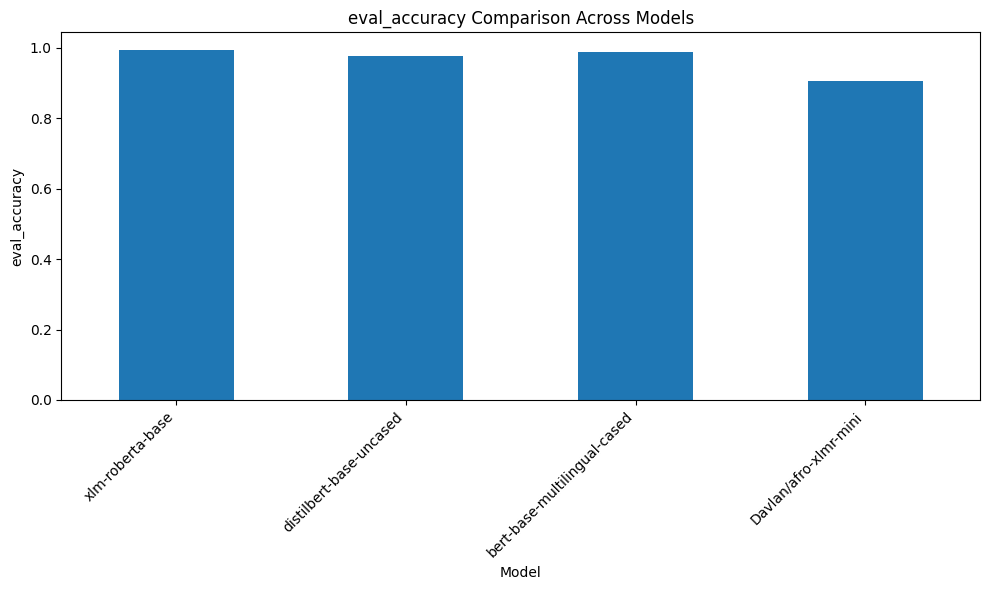

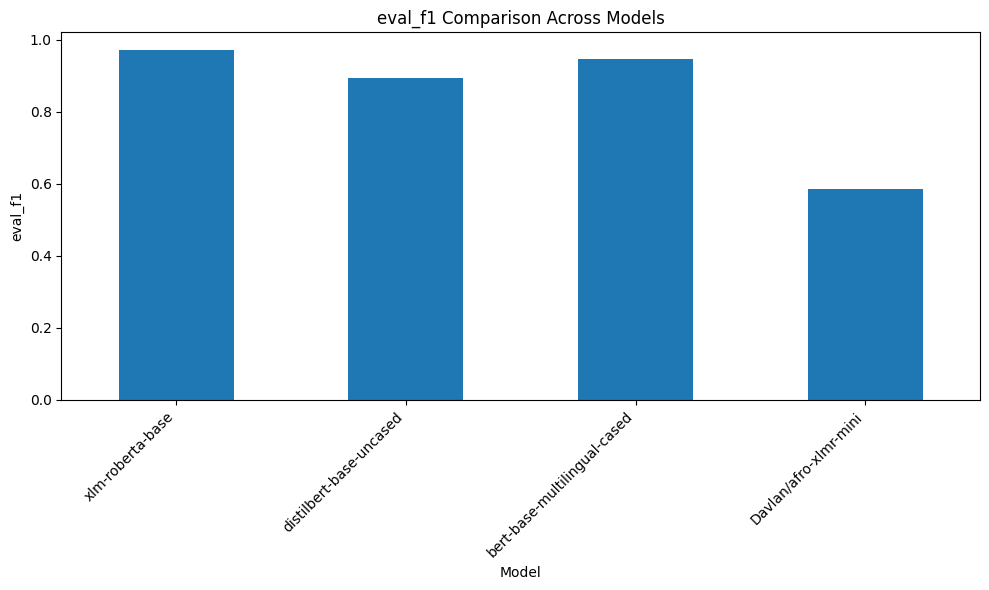

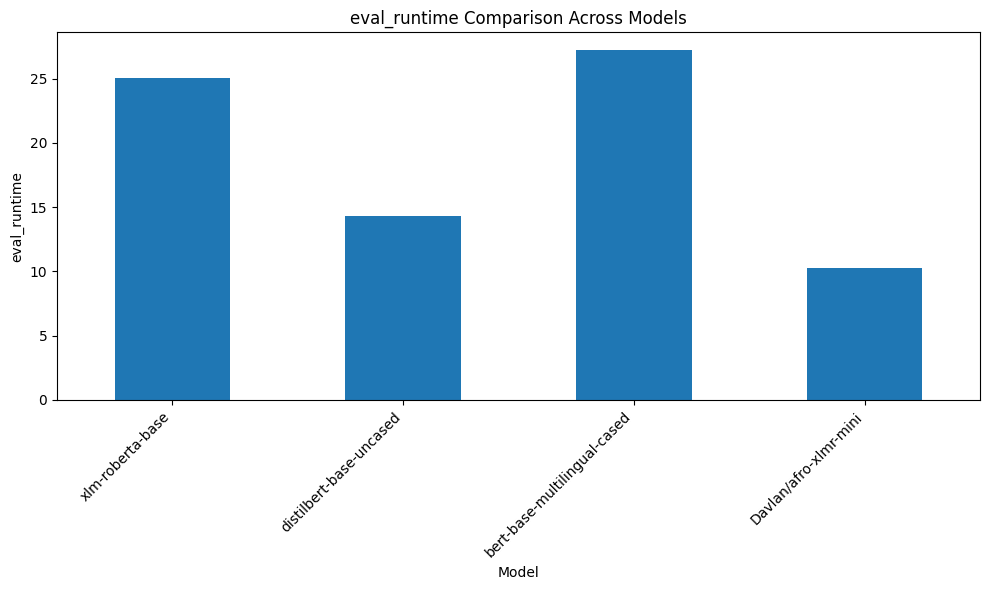


Model with the best accuracy: xlm-roberta-base
Model with the best F1-score: xlm-roberta-base


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the evaluation results dictionary to a pandas DataFrame for easier analysis
results_df = pd.DataFrame.from_dict(evaluation_results_dict, orient='index')

# Display the DataFrame with evaluation results
print("\n--- Evaluation Results Summary ---")
display(results_df)

# Select relevant metrics for comparison
comparison_metrics = ['eval_accuracy', 'eval_f1', 'eval_runtime']

# Create bar plots for each comparison metric
for metric in comparison_metrics:
    plt.figure(figsize=(10, 6))
    results_df[metric].plot(kind='bar')
    plt.title(f'{metric} Comparison Across Models')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Identify the best performing model based on accuracy and F1-score (higher is better)
best_accuracy_model = results_df['eval_accuracy'].idxmax()
best_f1_model = results_df['eval_f1'].idxmax()

print(f"\nModel with the best accuracy: {best_accuracy_model}")
print(f"Model with the best F1-score: {best_f1_model}")